## Isolation Forest

Partitions are created by first randomly selecting a feature and then selecting a random split value between the minimum and maximum value of the selected feature. In principle, outliers are less frequent than regular observations and are different from them in terms of values (they lie further away from the regular observations in the feature space). A normal point requires more partitions to be identified than an abnormal point.

Isolation based methods are different from others statistics, clustering or nearest- neighbors approaches because they don’t compute a distance or a density from the dataset. Therefore, they have a lower complexity and are more scalable. They don’t suffer from the problem of CPU, memory or time consumption. Thus, isolation based methods are adapted to the data stream context.

## Why we using Isolation Forest

Unsupervised Algorith for anomaly detection

Works well with streaming data, where the size of data is uncertain and data grows infinitely.

Can be used in any type of data(categorical or numerical). No feature scaling required.

Efficient method for anomaly detection with relatively low complexity, CPU and time consumption.

In [1]:
import pandas
import numpy as np
import pandas as pd
from urllib.parse import urlparse, parse_qs

from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.ensemble import IsolationForest

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = []

def file_to_dataframe(filepath, label_id):
    with open(filepath, 'r') as fd:
        lines = fd.readlines()
        request ={}
        for line in lines:
            if len(line.strip()) == 0:
                continue
            elif line.startswith('GET') or line.startswith('POST'):
                if request:
                    data.append(request)
                request ={}
                line = line.split()
                request['Http-Type'] = line[0]
                parsed_url = urlparse(line[1])
                request['Http-Url'] = parsed_url.netloc
                request['Http-Path'] = parsed_url.path
                request['Http-Query'] = parsed_url.query
                request['Label-Id'] = label_id
            elif ' ' in line:
                line = line.split(':')
                key = line[0]
                value = ':'.join(line[1:]).strip()
                request[key] = value
            else:
                request['Http-Query'] = line

In [3]:
file_to_dataframe('normalTrafficTraining.txt', 0)
file_to_dataframe('anomalousTrafficTest.txt', 1)

In [4]:
df = pandas.DataFrame(data=data)

In [5]:
df.nunique()

Http-Type              2
Http-Url              13
Http-Path           1633
Http-Query         23833
Label-Id               2
User-Agent             1
Pragma                 1
Cache-control          1
Accept                 1
Accept-Encoding        1
Accept-Charset         1
Accept-Language        1
Host                   2
Cookie             60666
Connection             1
Content-Type           1
Content-Length       382
PUT http               8
dtype: int64

**Using only Http-Path, and Http-Query feature. Other feature contains the same data in all rows.**

In [6]:
df = df[['Http-Path', 'Http-Query', 'Label-Id']]

In [7]:
df.head(5)

,Http-Path,Http-Query,Label-Id
0,/tienda1/index.jsp,,0
1,/tienda1/publico/anadir.jsp,id=3&nombre=Vino+Rioja&precio=100&cantidad=55&...,0
2,/tienda1/publico/anadir.jsp,id=3&nombre=Vino+Rioja&precio=100&cantidad=55&...,0
3,/tienda1/publico/autenticar.jsp,modo=entrar&login=choong&pwd=d1se3ci%F3n&remem...,0
4,/tienda1/publico/autenticar.jsp,modo=entrar&login=choong&pwd=d1se3ci%F3n&remem...,0


In [8]:
df.isnull().sum()

Http-Path     0
Http-Query    0
Label-Id      0
dtype: int64

**Converting string into numeric categorical data as we can see same data is repeated and while fitting the model numeric data is required.**

In [9]:
def convert_to_categorical(dataframe, column):
    dataframe[column] = dataframe[column].astype('category').cat.codes
    return dataframe

for col_name in list(df.columns):
    convert_to_categorical(df, col_name)

In [10]:
df.nunique()

Http-Path      1633
Http-Query    23833
Label-Id          2
dtype: int64

In [11]:
df.shape

(60666, 3)

**Applying MinMax Normalization in order to convert data into same scale ranging from 0-1. After normalization all the variables have a similar influence on the model.**

In [12]:
X = df[['Http-Path', 'Http-Query']]
max_min_scaler = preprocessing.MinMaxScaler()
data_scaled = max_min_scaler.fit_transform(X)
X = pd.DataFrame(data_scaled)

**Contamination = 0.5 as we have used 50 % of anomalous data and 50% of Normal data.**

In [13]:
model = IsolationForest(contamination=0.5, n_estimators=1000)

In [14]:
model.fit(X)

IsolationForest(contamination=0.5, n_estimators=1000)

In [15]:
anomaly_score = model.decision_function(X)

**IForest algorithm predict two classes -1 as anomalous and 1 as normal as a result. In our dataset we have lables 0 and 1 representing normal and anomalous data respectively. So, mapping -1(anomalous) to 1 and 1(normal) to 0 as in Label-Id.**

In [16]:
X['iforest'] = pd.Series(model.predict(X))
X['iforest'] = X['iforest'].map({1:0, -1:1})

In [17]:
print(X['iforest'].value_counts())

1    30333
0    30333
Name: iforest, dtype: int64


In [18]:
accuracy_score(X['iforest'], df['Label-Id'])

0.7334915768305146

In [19]:
X['labels'] = df['Label-Id']
X['Anomaly-Score'] = anomaly_score

In [20]:
X.columns = ['Http-Path', 'Http-Query', 'iforest', 'labels', 'Anomaly-Score']

**Anomaly Score ranges from -0.5 to 0.5, numbers near -0.5 represent anomaly and vice-versa.**

In [21]:
X

,Http-Path,Http-Query,iforest,labels,Anomaly-Score
0,0.484069,0.000000,0,0,0.022142
1,0.738971,0.181647,1,0,-0.016579
2,0.738971,0.181688,1,0,-0.016579
3,0.779412,0.259735,1,0,-0.005321
4,0.779412,0.259777,1,0,-0.005354
...,...,...,...,...,...
60661,0.535539,0.590047,1,1,-0.126100
60662,0.535539,0.618832,1,1,-0.107356
60663,0.535539,0.618874,1,1,-0.107316
60664,0.539828,0.000000,0,1,0.013239


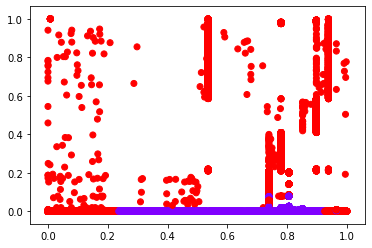

In [22]:
fig, ax1 = plt.subplots()
ax1.scatter(X['Http-Path'],X['Http-Query'], c=X['iforest'], cmap = 'rainbow')
plt.show()